In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from truck_company_analysis_utils import *
from ast import literal_eval
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, StratifiedKFold
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

from scipy import stats

In [40]:
original_previous = pd.read_csv("datasets/air_system_previous_years.csv")
original_present = pd.read_csv("datasets/air_system_present_year.csv")

print("Columns are equal on both datasets:", (original_previous.columns == original_present.columns).all()) # check if there are any new or differnt columns
print("previous data shape:", original_previous.shape)
print("present data shape:", original_present.shape)

Columns are equal on both datasets: True
previous data shape: (60000, 171)
present data shape: (16000, 171)


## Basic data treating

In [41]:
# handle missing data
original_previous.replace("na", np.nan, inplace=True)
original_present.replace("na", np.nan, inplace=True)

original_previous.iloc[:, 0].astype(str)
original_previous.iloc[:, 1:].astype(np.number)

original_present.iloc[:, 0] = original_present.iloc[:, 0].astype(str)
original_present.iloc[:, 1:] = original_present.iloc[:, 1:].astype(np.number)

C:\Users\pedro\AppData\Roaming\Python\Python313\site-packages\pandas\core\dtypes\common.py:1645: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
C:\Users\pedro\AppData\Roaming\Python\Python313\site-packages\pandas\core\dtypes\common.py:1645: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
C:\Users\pedro\AppData\Roaming\Python\Python313\site-packages\pandas\core\dtypes\common.py:1645: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
C:\Users\pedro\AppData\Roaming\Python\Python313\site-packages\pandas\core\dtypes\common.py:1645: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is dep

In [42]:
# calculate percentage of failure related to air system
previous_air_problems = original_previous.iloc[:, :2].groupby("class").count().loc["pos", original_previous.columns[1]]
print("Previous percentage of air system failures:", f"{previous_air_problems/600}%")

present_air_problems = original_present.iloc[:, :2].groupby("class").count().loc["pos", original_previous.columns[1]]
print("Present percentage of air system failures:", f"{present_air_problems/160}%")

Previous percentage of air system failures: 1.6666666666666667%
Present percentage of air system failures: 2.34375%


In [43]:
# adjust data types
previous = original_previous.copy()
previous["class"] = previous["class"].replace({"neg": 0, "pos": 1})
for column in previous.columns:
    previous[column] = previous[column].astype(np.number)

present = original_present.copy()
present["class"] = present["class"].replace({"neg": 0, "pos": 1})
for column in present.columns:
    present[column] = present[column].astype(np.number)

full_df = pd.concat([previous, present])
for column in full_df.columns:
    full_df[column] = full_df[column].astype(np.number)

C:\Users\pedro\AppData\Roaming\Python\Python313\site-packages\pandas\core\dtypes\common.py:1645: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
C:\Users\pedro\AppData\Roaming\Python\Python313\site-packages\pandas\core\dtypes\common.py:1645: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
C:\Users\pedro\AppData\Roaming\Python\Python313\site-packages\pandas\core\dtypes\common.py:1645: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
C:\Users\pedro\AppData\Roaming\Python\Python313\site-packages\pandas\core\dtypes\common.py:1645: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is dep

### Removing columns with too many nulls

In [44]:
# check number of positives vs negatives on class
print(previous[previous["class"] == 1].shape)
print(present[present["class"] == 1].shape)

(1000, 171)
(375, 171)


Text(0.5, 1.0, 'Percentage of null values on failed Air System')

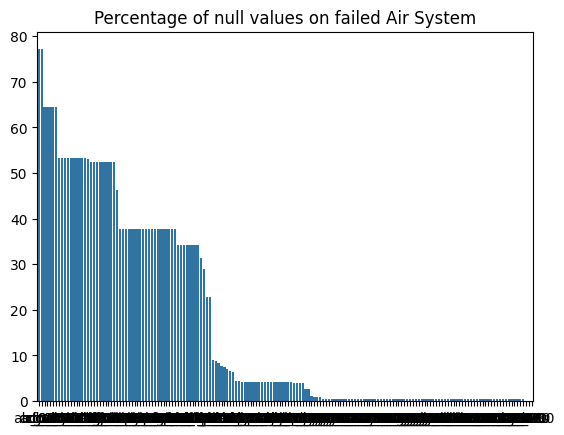

In [45]:
#### get percentage of null values where class = pos on previous dataframe
percentage_of_na_values_previous = previous[previous["class"] == 1].isna().sum().sort_values(ascending=False)/10
fig = sns.barplot(data=percentage_of_na_values_previous)
fig.set_title("Percentage of null values on failed Air System")

Text(0.5, 1.0, 'Percentage of null values on failed air System')

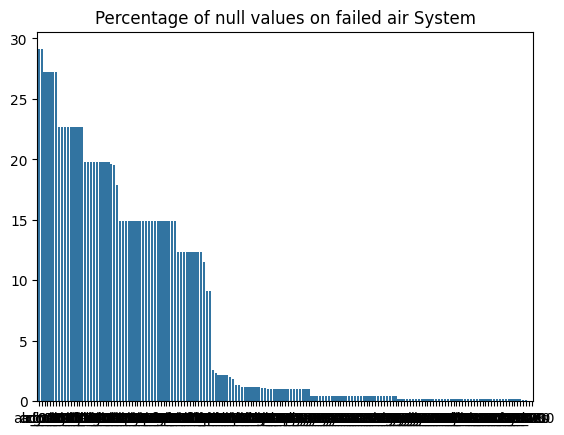

In [46]:
#### get percentage of null values where class = pos on present dataframe
percentage_of_na_values_present = present[present["class"] == 1].isna().sum().sort_values(ascending=False)/10
fig = sns.barplot(data=percentage_of_na_values_present)
fig.set_title("Percentage of null values on failed air System")

In [47]:
#### Remove columns with more than p% missing data
p = 20

columns_to_remove_previous = set(percentage_of_na_values_previous[percentage_of_na_values_previous > 20].index)
columns_to_remove_present = set(percentage_of_na_values_present[percentage_of_na_values_present > 20].index)
# print(columns_to_remove_previous)
# print(columns_to_remove_present)
# print(columns_to_remove_present - columns_to_remove_previous)

columns_to_remove = columns_to_remove_previous & columns_to_remove_present
previous.drop(columns=columns_to_remove, axis="columns", inplace=True)
present.drop(columns=columns_to_remove, axis="columns", inplace=True)
full_df.drop(columns=columns_to_remove, axis="columns", inplace=True)


The two graphs above represent the percentages of null values on each dataset for lines in which the air system broke. Only a very small percentage of the lines were classified with air system problems, so it's important to rule out columns with too many nulls because they won't have much useful information and take time to be analysed and processed. So columns with more than 20% of na values were discarted

Text(0.5, 1.0, 'Percentage of null values')

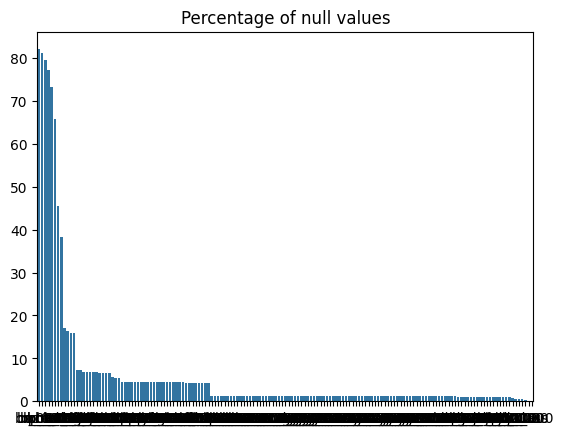

In [48]:
#### get percentage of null values
percentage_of_na_values_previous = previous.isna().sum().sort_values(ascending=False)/600
fig = sns.barplot(data=percentage_of_na_values_previous)
fig.set_title("Percentage of null values")

Text(0.5, 1.0, 'Percentage of null values')

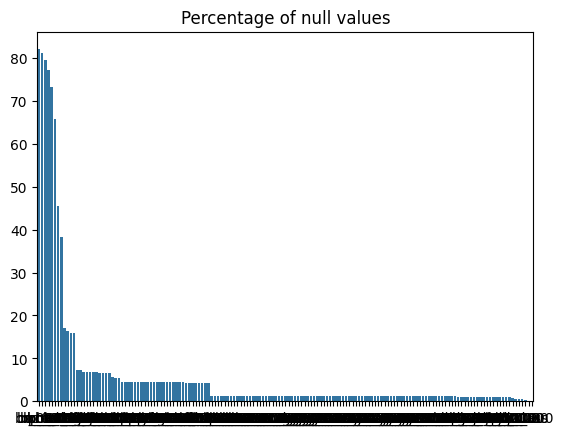

In [49]:
#### get percentage of null values
percentage_of_na_values_present = present.isna().sum().sort_values(ascending=False)/160
fig = sns.barplot(data=percentage_of_na_values_previous)
fig.set_title("Percentage of null values")

In [50]:
#### Remove columns with more than p% missing data
p = 50

columns_to_remove_previous = set(percentage_of_na_values_previous[percentage_of_na_values_previous > 20].index)
columns_to_remove_present = set(percentage_of_na_values_present[percentage_of_na_values_present > 20].index)
# print(columns_to_remove_previous)
# print(columns_to_remove_present)
# print(columns_to_remove_present - columns_to_remove_previous)

columns_to_remove = columns_to_remove_previous & columns_to_remove_present
previous.drop(columns=columns_to_remove, axis="columns", inplace=True)
present.drop(columns=columns_to_remove, axis="columns", inplace=True)
full_df.drop(columns=columns_to_remove, axis="columns", inplace=True)


The two graphs above represent the percentages of null values on each dataset for all lines. As there are many more lines a percentage of 40% was set to rule out columns with too many null values

## Feature selection

### Discard variables correlated to each other

In [51]:
####### Calculate Pearson, Spearman and Point Biserial Correlations to both dataframes

##### Pearson Correlations
previous_correlations_path = "correlation_matrices/previous.csv"
if os.path.exists(previous_correlations_path):
    correlations_previous = pd.read_csv(previous_correlations_path, index_col=0)
else:
    correlations_previous = previous.corr()
    correlations_previous.to_csv(previous_correlations_path)

present_correlations_path = "correlation_matrices/present.csv"
if os.path.exists(present_correlations_path):
    correlations_present = pd.read_csv(present_correlations_path, index_col=0)
else:
    correlations_present = present.corr()
    correlations_present.to_csv(present_correlations_path)

full_df_correlations_path = "correlation_matrices/full_df.csv"
if os.path.exists(full_df_correlations_path):
    correlations = pd.read_csv(full_df_correlations_path, index_col=0)
else:
    correlations = full_df.corr()
    correlations.to_csv(full_df_correlations_path)

#### Spearman Correlations
previous_correlations_path = "correlation_matrices/spearman_previous.csv"
if os.path.exists(previous_correlations_path):
    spearman_correlations_previous = pd.read_csv(previous_correlations_path, index_col=0)
else:
    spearman_correlations_previous = previous.corr(method="spearman")
    spearman_correlations_previous.to_csv(previous_correlations_path)

present_correlations_path = "correlation_matrices/spearman_present.csv"
if os.path.exists(present_correlations_path):
    spearman_correlations_present = pd.read_csv(present_correlations_path, index_col=0)
else:
    spearman_correlations_present = present.corr(method="spearman")
    spearman_correlations_present.to_csv(present_correlations_path)

full_df_correlations_path = "correlation_matrices/spearman_full_df.csv"
if os.path.exists(full_df_correlations_path):
    spearman_correlations = pd.read_csv(full_df_correlations_path, index_col=0)
else:
    spearman_correlations = full_df.corr(method="spearman")
    spearman_correlations.to_csv(full_df_correlations_path)

#### Point Biserial (to class column)
previous_correlations_path = "correlation_matrices/point_biserial_previous.csv"
if os.path.exists(previous_correlations_path):
    pb_correlations_previous = pd.read_csv(previous_correlations_path, index_col=0)
else:
    pb_correlations_previous = calculate_point_biserial(previous, "class", previous.columns[1:])
    pb_correlations_previous.set_index("column")
    pb_correlations_previous.to_csv(previous_correlations_path)

present_correlations_path = "correlation_matrices/point_biserial_present.csv"
if os.path.exists(present_correlations_path):
    pb_correlations_present = pd.read_csv(present_correlations_path, index_col=0)
else:
    pb_correlations_present = calculate_point_biserial(present, "class", present.columns[1:])
    pb_correlations_present.set_index("column")
    pb_correlations_present.to_csv(present_correlations_path)

full_df_correlations_path = "correlation_matrices/point_biserial_full_df.csv"
if os.path.exists(full_df_correlations_path):
    pb_correlations = pd.read_csv(full_df_correlations_path, index_col='column')
else:
    pb_correlations = calculate_point_biserial(full_df, "class", full_df.columns[1:])
    pb_correlations.set_index("column", inplace=True)
    pb_correlations.to_csv(full_df_correlations_path)
pb_correlations["correlation"] = pb_correlations["correlation"].abs() # the module is better for comparison to others

In [52]:
# map high correlations
threshold = 0.75

correlations_mapped = map_high_correlations(correlations, threshold=threshold)

In [53]:
correlations

,class,aa_000,ac_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
class,1.000000,0.323466,-0.039261,0.005740,0.016127,0.018198,0.157296,0.336957,0.436378,0.384952,...,0.466371,0.455595,0.443929,0.503462,0.425457,0.177196,0.239756,0.119087,0.015204,0.013075
aa_000,0.323466,1.000000,-0.032347,0.061710,0.086110,0.011695,0.076467,0.195389,0.307803,0.357875,...,0.414668,0.420463,0.410197,0.420331,0.426238,0.357437,0.260009,0.133939,0.016892,0.026091
ac_000,-0.039261,-0.032347,1.000000,-0.004815,-0.010873,0.015633,-0.002749,-0.014891,-0.035797,-0.047488,...,-0.014406,-0.008913,-0.010956,-0.012941,-0.022056,-0.029158,0.014777,0.020837,-0.006539,0.015826
ae_000,0.005740,0.061710,-0.004815,1.000000,0.829986,-0.000442,-0.000685,0.002665,0.028046,0.062227,...,0.016893,0.024749,0.016157,0.036121,0.088900,0.050955,-0.010310,-0.008024,0.063627,0.030873
af_000,0.016127,0.086110,-0.010873,0.829986,1.000000,-0.000542,-0.000830,0.005973,0.041840,0.089982,...,0.029878,0.043663,0.027690,0.058755,0.129903,0.064733,-0.013332,-0.009863,0.093482,0.044372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ee_007,0.177196,0.357437,-0.029158,0.050955,0.064733,0.007631,0.068044,0.182553,0.476482,0.709791,...,0.442199,0.432911,0.419633,0.380132,0.543449,1.000000,0.227098,0.063065,-0.000444,0.001417
ee_008,0.239756,0.260009,0.014777,-0.010310,-0.013332,0.000067,0.005356,0.009138,0.020724,0.058025,...,0.442532,0.470574,0.448390,0.394020,0.365686,0.227098,1.000000,0.690147,-0.006386,-0.002405
ee_009,0.119087,0.133939,0.020837,-0.008024,-0.009863,-0.001103,-0.003542,-0.009119,-0.018198,-0.015406,...,0.224587,0.235844,0.220785,0.183844,0.158590,0.063065,0.690147,1.000000,-0.003655,-0.001222
ef_000,0.015204,0.016892,-0.006539,0.063627,0.093482,-0.000076,0.001307,0.008245,0.015860,0.017457,...,0.005134,0.013453,0.003919,0.039535,0.007457,-0.000444,-0.006386,-0.003655,1.000000,0.222579


In [54]:
## If columns have high correlation, remove the one with lower point biserial correlation to class column
columns_to_remove = set()
for column in correlations_mapped.keys():
    for other_column in correlations_mapped[column]:
        corr_1 = pb_correlations.loc[column, "correlation"]
        corr_2 = pb_correlations.loc[other_column, "correlation"]
        column_to_remove = column if corr_1 < corr_2 else other_column
        columns_to_remove.add(column_to_remove)
columns_to_remove = columns_to_remove & set(full_df.columns)
print(columns_to_remove)

{'ee_002', 'ba_004', 'ag_002', 'cb_000', 'cl_000', 'bx_000', 'ap_000', 'ba_002', 'ba_001', 'ba_006', 'dl_000', 'ao_000', 'cs_005', 'ca_000', 'ag_004', 'cn_002', 'cs_004', 'ak_000', 'cn_003', 'al_000', 'az_005', 'ck_000', 'bv_000', 'dt_000', 'do_000', 'cs_002', 'an_000', 'cc_000', 'ed_000', 'ba_003', 'ee_005', 'az_004', 'bg_000', 'az_002', 'cs_000', 'du_000', 'cn_004', 'ba_007', 'bb_000', 'ag_006', 'bi_000', 'ee_004', 'ae_000', 'ba_000', 'dp_000', 'ah_000', 'aq_000', 'bu_000', 'by_000', 'ee_003', 'ee_000', 'ba_005', 'ec_00', 'cn_001', 'ag_005', 'ds_000', 'ay_007', 'cn_006', 'dn_000', 'ay_002', 'ag_001', 'ay_008', 'ag_007', 'aa_000', 'cn_005', 'ee_007', 'bj_000', 'cq_000', 'cs_003', 'bt_000', 'ee_001', 'cn_008', 'cn_007', 'dd_000', 'ay_006', 'bh_000', 'ee_006'}


In [55]:
# drop unnecessary features
previous.drop(columns_to_remove, axis='columns', inplace=True)
present.drop(columns_to_remove, axis='columns', inplace=True)
full_df.drop(columns_to_remove, axis='columns', inplace=True)

It's possible that some variables are lienarly correlated to each other and since there's no information about what each of them represents, it's better to keep only one of each. So:
- Pearson correlations were calculated for each pair of variables and if the result was greater than 75% they were considered colinear.
- Point Biserial correlations were calculated between each variable and the class column.
- Only the colinear variable with the higher Point Biserial correlation was kept.

### Analyse distribution changes

In [56]:
# check distribution changes over time
percentage_filter = 0.5

p_values = pd.Series(index=previous.columns)
for column in previous.columns:
    ks_stat, p_value = stats.ks_2samp(previous[column].dropna(), present[column].dropna())    
    p_values.loc[column] = p_value

p_values_sorted = p_values.sort_values()

diff_dist_time = set(p_values_sorted[p_values_sorted < percentage_filter])

After performing the KS test, these variables are the ones with less than 50% chance of being the same distribution on the previous years dataset and the present year dataset. This means that they are candidates to explain the increase in cost with air system even though the number of trucks is still the same

In [57]:
# check distribution changes from positive to negative classification
percentage_filter = 0.5

p_values = pd.Series(index=previous.columns)
for column in previous.columns:
    no_air_problem = previous[column].dropna()
    ks_stat, p_value = stats.ks_2samp(
        previous[previous["class"] == 0][column].dropna(),
        previous[previous["class"] == 1][column].dropna()
    )    
    p_values.loc[column] = p_value

p_values_prev = p_values.sort_values()
diff_dist_previous = set(p_values_sorted[p_values_sorted < percentage_filter].index)

p_values = pd.Series(index=present.columns)
for column in present.columns:
    no_air_problem = present[column].dropna()
    ks_stat, p_value = stats.ks_2samp(
        present[present["class"] == 0][column].dropna(),
        present[present["class"] == 1][column].dropna()
    )      
    p_values.loc[column] = p_value

p_values_pres = p_values.sort_values()
diff_dist_present = set(p_values_sorted[p_values_sorted < percentage_filter].index)

In [58]:
print("Different distributions from no failure to failure in the past:", len(diff_dist_previous))
print("Different distributions from no failure to failure in the present:", len(diff_dist_present))
display(len(diff_dist_previous - diff_dist_present))
display(len(diff_dist_present - diff_dist_previous))

Different distributions from no failure to failure in the past: 19
Different distributions from no failure to failure in the present: 19


0

0

The same ditributions were different separating by class both in the past and present datasets. This is a good indicator that these variables are useful for tracking air system problems

In [59]:
print("Length of the intersection between variables that changed over time and class:", len(diff_dist_time & diff_dist_present))

Length of the intersection between variables that changed over time and class: 0


This shows no intersection between the variables' distributions that changed over time and the variables distributions' that changed from positive to negative on class

In [60]:
# check distribution changes over time, but with equal amount of data from each classification
percentage_filter = 0.5

p_values = pd.Series(index=previous.columns)
for column in previous.columns:
    previous_sampled = previous[previous["class"] == 0][column].dropna().sample(1000)
    present_sampled = present[present["class"] == 0][column].dropna().sample(375)

    previous_test = pd.concat([previous_sampled, previous[previous["class"] == 1][column].dropna()])
    present_test = pd.concat([present_sampled, present[present["class"] == 1][column].dropna()])    

    ks_stat, p_value = stats.ks_2samp(previous[column].dropna(), present[column].dropna())    
    p_values.loc[column] = p_value

p_values_time = p_values.sort_values()

diff_dist_time = set(p_values_sorted[p_values_sorted < percentage_filter].index)

In [61]:
print("Number of variables selected by difference from previous to present:", len(diff_dist_time))
print("Number of variables selected that intersect with the selected from no air system failure to air system failure:", len(diff_dist_time))

Number of variables selected by difference from previous to present: 19
Number of variables selected that intersect with the selected from no air system failure to air system failure: 19


This time, the difference from previous to present test is done again, but this time with an aproximate number of samples that had and didn't have air system failures, so that the distribution of no failure takes over due to it's significantly higher amount of samples. The result is a subset of the 56 variables selected from the difference in the distribution from no air system failure to air system failure. It indicates that these were the variables that caused the increase of air system failures over time. 

### Create a ranking of features

In [62]:
# create the p_values from ks test between class with full df
p_values = pd.Series(index=full_df.columns)
for column in full_df.columns:
    no_air_problem = full_df[column].dropna()
    ks_stat, p_value = stats.ks_2samp(
        full_df[full_df["class"] == 0][column].dropna(),
        full_df[full_df["class"] == 1][column].dropna()
    )    
    p_values.loc[column] = p_value

p_values_full = p_values.sort_values()
diff_dist_full_df = set(p_values_sorted[p_values_sorted < percentage_filter].index)

In [63]:
# rank features
feature_ranking = pd.DataFrame(index=p_values_time.index)
feature_ranking.loc[p_values_time.index, "p_values_time"] = 1 - p_values_time
feature_ranking.loc[p_values_full.index, "p_values_full"] =  1 - p_values_full
feature_ranking.loc[feature_ranking.drop(index="class").index, "pb_correlation"] = pb_correlations.loc[feature_ranking.drop(index="class").index, "correlation"]
feature_ranking["ranking"] = feature_ranking[["p_values_time", "p_values_full", "pb_correlation"]].sum(axis=1)

ranked_features = feature_ranking["ranking"].sort_values(ascending=False).index

feature_ranking.head()

,p_values_time,p_values_full,pb_correlation,ranking
bz_000,0.912380,1.0,0.219723,2.132102
bs_000,0.891156,1.0,0.201157,2.092313
dv_000,0.867932,1.0,0.270457,2.138389
az_006,0.863455,1.0,0.086948,1.950403
cs_001,0.785624,1.0,0.329096,2.114720


The ranking was made using a mix of the analysis done so far. The features are ranked by the sum of the p values from the difference of distributions in time, the p values from from the difference in distribution between positive and negative cases and the point biserial correlation to the class column.

## Choice of model

### Separate train data from test data and define loss function

In [64]:
X = full_df.dropna()[list(diff_dist_full_df)].copy()
y = full_df.dropna()[["class"]].copy()

# separate train data from test data and define loss function
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

def custom_loss(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 10 * fp + 500 * fn

custom_scorer = make_scorer(custom_loss, greater_is_better=False)

## Initialize models

In [65]:
# initialize models (base versions)
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', class_weight={0:1, 1:50}),
    "Decision Tree": DecisionTreeClassifier(class_weight={0:1, 1:50}),
    "Random Forest": RandomForestClassifier(class_weight={0:1, 1:50}),
    "XGBoost": XGBClassifier(scale_pos_weight=50, eval_metric='logloss')
}

## Feature selection

In [66]:
def select_features_l1(X, y, C=0.1):
    selector = SelectFromModel(
        LogisticRegression(penalty='l1', C=C, solver='liblinear', class_weight={0:1, 1:50}),
        max_features=None  # No limit on features
    )
    selector.fit(X, y)
    return X.columns[selector.get_support()]

def select_features_tree(model, X, y):
    model.fit(X, y)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        importances = model.get_booster().get_score(importance_type='weight')
    selected = X.columns[importances > np.mean(importances)]
    return selected

## Hyperparameter tuning (GridSearchCV)

In [67]:
models = {
    "Logistic Regression": {
        "model": LogisticRegression(class_weight={0:1, 1:50}, max_iter=1000),
        "param_grid": {'C': [0.01, 0.1, 1], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
        "feature_selector": lambda X, y: select_features_l1(X, y)
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(class_weight={0:1, 1:50}),
        "param_grid": {'max_depth': [1, 2, 3, 5], 'min_samples_split': [1, 2, 5]},
        "feature_selector": lambda X, y: select_features_tree(DecisionTreeClassifier(), X, y)
    },
    "Random Forest": {
        "model": RandomForestClassifier(class_weight={0:1, 1:50}),
        "param_grid": {'n_estimators': [50, 100, 200], 'max_depth': [2, 3, 5]},
        "feature_selector": lambda X, y: select_features_tree(RandomForestClassifier(), X, y)
    },
    "XGBoost": {
        "model": XGBClassifier(scale_pos_weight=50, eval_metric='logloss'),
        "param_grid": {'n_estimators': [50, 100, 200], 'max_depth': [1, 2, 3, 5, 7], 'learning_rate': [0.01, 0.1]},
        "feature_selector": lambda X, y: select_features_tree(XGBClassifier(), X, y)
    }
}

results = {}

for name, config in models.items():
    print(f"\n--- {name} ---")

    selected_features = config["feature_selector"](X_train, y_train)
    print(f"Selected features: {list(selected_features)}")

    grid = GridSearchCV(
        estimator=config["model"],
        param_grid=config["param_grid"],
        scoring=custom_scorer,
        cv=5,
        n_jobs=-1
    )
    grid.fit(X_train[selected_features], y_train)

    results[name] = {
        "model": grid.best_estimator_,
        "features": selected_features,
        "best_params": grid.best_params_,
        "best_loss": custom_loss(y_test, grid.best_estimator_.predict(X_test[selected_features]))
    }
    print(f"Best params: {grid.best_params_}")
    print(f"Test loss: {results[name]['best_loss']:.2f}")


--- Logistic Regression ---
Selected features: ['be_000', 'de_000', 'cs_001', 'az_001', 'cs_008']
Best params: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Test loss: 29010.00

--- Decision Tree ---
Selected features: ['am_0', 'dy_000', 'ci_000']
Best params: {'max_depth': 3, 'min_samples_split': 2}
Test loss: 10500.00

--- Random Forest ---
Selected features: ['am_0', 'az_001', 'az_000', 'ci_000']
Best params: {'max_depth': 2, 'n_estimators': 200}
Test loss: 10960.00

--- XGBoost ---
Selected features: ['am_0', 'ai_000', 'az_003', 'ci_000']
Best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Test loss: 10180.00


## Threshold optimization

In [68]:
def find_optimal_threshold(model, X, y_true):
    y_proba = model.predict_proba(X)[:, 1]
    thresholds = np.linspace(0, 1, 100)
    best_loss = float('inf')
    best_thresh = 0.5
    
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        loss = custom_loss(y_true, y_pred)
        if loss < best_loss:
            best_loss = loss
            best_thresh = thresh
    
    return best_thresh

for name in results.keys():
    X_test_sub = X_test[results[name]["features"]]
    results[name]["threshold"] = find_optimal_threshold(results[name]["model"], X_test_sub, y_test)
    print(f"{name}: Optimal threshold = {results[name]['threshold']:.2f}")

Logistic Regression: Optimal threshold = 0.39
Decision Tree: Optimal threshold = 0.22
Random Forest: Optimal threshold = 0.59
XGBoost: Optimal threshold = 0.62


## Final Evaluation

In [69]:
# Test data evaluation
for name, data in results.items():
    X_test_sub = X_test[data["features"]]
    y_proba = data["model"].predict_proba(X_test_sub)[:, 1]
    y_pred = (y_proba >= data["threshold"]).astype(int)
    loss = custom_loss(y_test, y_pred)
    print(f"\n{name} (Threshold={data['threshold']:.2f}):")
    print(f"Final Test Loss: {loss:.2f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


Logistic Regression (Threshold=0.39):
Final Test Loss: 27190.00
Confusion Matrix:
[[17609   669]
 [   41   117]]

Decision Tree (Threshold=0.22):
Final Test Loss: 10500.00
Confusion Matrix:
[[17628   650]
 [    8   150]]

Random Forest (Threshold=0.59):
Final Test Loss: 10010.00
Confusion Matrix:
[[17727   551]
 [    9   149]]

XGBoost (Threshold=0.62):
Final Test Loss: 9500.00
Confusion Matrix:
[[17778   500]
 [    9   149]]


In [78]:
# Cross-Validation Evaluation
def evaluate_with_cv(models, X, y, n_splits=5, random_state=42):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    results = {}
    
    for name, model in models.items():
        scores = -cross_val_score(
            estimator=model,
            X=X,
            y=y,
            scoring=custom_scorer,
            cv=cv,
            n_jobs=-1
        )
        results[name] = (np.mean(scores), np.std(scores))
        print(f"{name}: Mean Loss = {results[name][0]:.2f} ± {results[name][1]:.2f}")
    
    return results

final_models = {
    "Logistic Regression": results["Logistic Regression"]["model"],
    "Decision Tree": results["Decision Tree"]["model"],
    "Random Forest": results["Random Forest"]["model"],
    "XGBoost": results["XGBoost"]["model"],
}


cv_results = evaluate_with_cv(final_models, X, y, n_splits=5)

from scipy.stats import ttest_rel

def compare_models_cv(models, X, y, n_splits=5):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    model_scores = {}

    for name, model in models.items():
        model_scores[name] = -cross_val_score(
            model, X, y, scoring=custom_scorer, cv=cv, n_jobs=-1
        )

    model_names = list(models.keys())
    for i in range(len(model_names)):
        for j in range(i+1, len(model_names)):
            m1, m2 = model_names[i], model_names[j]
            t_stat, p_val = ttest_rel(model_scores[m1], model_scores[m2])
            print(f"{m1} vs {m2}: p-value = {p_val:.4f}")
            if p_val < 0.05:
                winner = m1 if np.mean(model_scores[m1]) < np.mean(model_scores[m2]) else m2
                print(f"  → {winner} is significantly better (p < 0.05)")

compare_models_cv(final_models, X, y)

Logistic Regression: Mean Loss = 16752.00 ± 2325.07
Decision Tree: Mean Loss = 8138.00 ± 1641.58
Random Forest: Mean Loss = 9124.00 ± 1392.16
XGBoost: Mean Loss = 7798.00 ± 1502.36
Logistic Regression vs Decision Tree: p-value = 0.0003
  → Decision Tree is significantly better (p < 0.05)
Logistic Regression vs Random Forest: p-value = 0.0007
  → Random Forest is significantly better (p < 0.05)
Logistic Regression vs XGBoost: p-value = 0.0006
  → XGBoost is significantly better (p < 0.05)
Decision Tree vs Random Forest: p-value = 0.3080
Decision Tree vs XGBoost: p-value = 0.3645
Random Forest vs XGBoost: p-value = 0.1629


From the results above it seems like the XGBoost is the best model for this problem

## Train the definitive model

In [94]:
data = full_df[results["XGBoost"]["features"]]
data["class"] = full_df["class"]
data.dropna(inplace=True)
y = data.pop("class")

xgboost_model = XGBClassifier(scale_pos_weight=50, eval_metric='logloss', **results["XGBoost"]["best_params"])
xgboost_model.fit(data, y)
None
